<a href="https://colab.research.google.com/github/aldebaro/ai6g/blob/main/solutions_06_channel_compression_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inteligência Artificial e Aprendizado de Máquina Aplicados a Redes 5G e 6G**.
*Aldebaro Klautau* (UFPA). Minicurso 5 do SBrT - 25 de setembro de 2022.

# Channel Compression with CSInet

This notebook contains the cells responsible for training the autoencoder/CNN model called CsiNet, which is used for CSI compression. The original code is at https://github.com/sydney222/Python_CsiNet and the corresponding paper is:
C. -K. Wen, W. -T. Shih and S. Jin, "Deep Learning for Massive MIMO CSI Feedback," in IEEE Wireless Communications Letters, vol. 7, no. 5, pp. 748-751, Oct. 2018, doi: 10.1109/LWC.2018.2818160.

### Collaborators
- *Lucas Damasceno* - M.Sc. student in Electrical Engineering (UFPA) | Researcher at LASSE - Telecommunications, Automation and Electronics R&D Center
- *Marcos Davi* - M.Sc. student in Electrical Engineering (UFPA) | Researcher at LASSE - Telecommunications, Automation and Electronics R&D Center

In [ ]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    import sys
    import os
    try:
      !git clone https://github.com/aldebaro/ai6g.git
    except:
      print("ai6g is already in the contents")
    %cd ai6g
    !ln -s /content/drive/MyDrive/ai6g_files/files_06_channel/* ./files_06_channel
    !pip install -r requirements.txt

In [1]:
# Import necessary modules
import math
import time
import numpy as np
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, BatchNormalization, Reshape, Conv2D, add, LeakyReLU
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, Callback
tf.compat.v1.reset_default_graph()

2022-09-20 15:01:38.662925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 15:01:38.804359: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 15:01:39.278227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-20 15:01:39.278279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# Set image and network params
envir = 'indoor' #'indoor' or 'outdoor'

# Using TensorFlow with CPU or GPU
GPU_Availability = 0 # 0 for CPU or 1 for GPU

# Image params
img_height = 32
img_width = 32
img_channels = 2 
img_total = img_height*img_width*img_channels

# Network params
residual_num = 1 #original value = 2
#compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32
encoded_dim = 32 #original value = 512

In [3]:
# Build the autoencoder model (CNN model) of CsiNet
if GPU_Availability == 0:
    dataFormat = 'channels_last'
    reshapeFormat = [img_height, img_width, img_channels]
else:
    dataFormat = 'channels_first'
    reshapeFormat = [img_channels, img_height, img_width]

def residual_network(x, residual_num, encoded_dim):
  def add_common_layers(y):
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)
    
    return y
  
  def residual_block_decoded(y):
    shortcut = y
    y = Conv2D(8, kernel_size=(3, 3), padding='same', data_format=dataFormat)(y)
    y = add_common_layers(y)
    
    y = Conv2D(16, kernel_size=(3, 3), padding='same', data_format=dataFormat)(y)
    y = add_common_layers(y)
    
    y = Conv2D(2, kernel_size=(3, 3), padding='same', data_format=dataFormat)(y)
    y = BatchNormalization()(y)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y
  
  x = Conv2D(2, (3, 3), padding='same', data_format=dataFormat)(x)
  x = add_common_layers(x)
  
  x = Reshape((img_total,))(x)
  encoded = Dense(encoded_dim, activation='linear')(x)
  
  x = Dense(img_total, activation='linear')(encoded)
  x = Reshape((reshapeFormat[0], reshapeFormat[1], reshapeFormat[2],))(x)
  for i in range(residual_num):
    x = residual_block_decoded(x)
  
  x = Conv2D(2, (3, 3), activation='sigmoid', padding='same', data_format=dataFormat)(x)
  
  return x

In [4]:
# Set autoencoder model params and display the network model
image_tensor = Input(shape=(reshapeFormat[0], reshapeFormat[1], reshapeFormat[2]))
network_output = residual_network(image_tensor, residual_num, encoded_dim)
autoencoder = Model(inputs=[image_tensor], outputs=[network_output])
autoencoder.compile(optimizer='adam', loss='mse')
print(autoencoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 32, 32)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 2, 32, 32)    38          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2, 32, 32)   128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 2, 32, 32)    0           ['batch_normalization[0][0]']

2022-09-20 15:01:48.406513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 15:01:48.413349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 15:01:48.413578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 15:01:48.414110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
# Load dataset
mat = sio.loadmat('files_06_channel/data/DATA_Htrainin_10k.mat') 
x_train = mat['HT'] # array
mat = sio.loadmat('files_06_channel/data/DATA_Hvalin_3k.mat')
x_val = mat['HT'] # array
mat = sio.loadmat('files_06_channel/data/DATA_Htestin_2k.mat')
x_test = mat['HT'] # array

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train = np.reshape(x_train, (len(x_train), reshapeFormat[0], reshapeFormat[1], reshapeFormat[2]))
x_val = np.reshape(x_val, (len(x_val), reshapeFormat[0], reshapeFormat[1], reshapeFormat[2]))
x_test = np.reshape(x_test, (len(x_test), reshapeFormat[0], reshapeFormat[1], reshapeFormat[2]))

In [6]:
# Create a class to save the loss history of the model
class LossHistory(Callback):
  def on_train_begin(self, logs={}):
    self.losses_train = []
    self.losses_val = []
  
  def on_batch_end(self, batch, logs={}):
    self.losses_train.append(logs.get('loss'))    
    
  def on_epoch_end(self, epoch, logs={}):
    self.losses_val.append(logs.get('val_loss'))

history = LossHistory()
file = 'CsiNet_'+(envir)+'_dim'+str(encoded_dim)+time.strftime('_%m_%d')
path = 'files_06_channel/result/TensorBoard_%s' %file

In [7]:
# Train the model with the specified params and save the train loss and val loss in a csv file
autoencoder.fit(x_train, x_train,
                epochs=10, #original value = 1000
                batch_size=20, #original value = 200
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[history,
                           TensorBoard(log_dir = path)])

filename = 'files_06_channel/result/trainloss_%s.csv'%file
loss_history = np.array(history.losses_train)
np.savetxt(filename, loss_history, delimiter=",")

filename = 'files_06_channel/result/valloss_%s.csv'%file
loss_history = np.array(history.losses_val)
np.savetxt(filename, loss_history, delimiter=",")

Epoch 1/10


2022-09-20 15:02:18.988846: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


500/500 [==============================] - 7s 7ms/step - loss: 9.6685e-04 - val_loss: 4.7973e-04
Epoch 2/10
500/500 [==============================] - 3s 7ms/step - loss: 4.6052e-04 - val_loss: 4.6164e-04
Epoch 3/10
500/500 [==============================] - 3s 7ms/step - loss: 4.5170e-04 - val_loss: 4.5609e-04
Epoch 4/10
500/500 [==============================] - 3s 7ms/step - loss: 4.3388e-04 - val_loss: 4.2407e-04
Epoch 5/10
500/500 [==============================] - 3s 7ms/step - loss: 4.0478e-04 - val_loss: 3.8890e-04
Epoch 6/10
500/500 [==============================] - 4s 7ms/step - loss: 3.7489e-04 - val_loss: 3.6566e-04
Epoch 7/10
500/500 [==============================] - 3s 7ms/step - loss: 3.5301e-04 - val_loss: 3.4393e-04
Epoch 8/10
500/500 [==============================] - 3s 7ms/step - loss: 3.3674e-04 - val_loss: 3.3112e-04
Epoch 9/10
500/500 [==============================] - 3s 7ms/step - loss: 3.2491e-04 - val_loss: 3.2115e-04
Epoch 10/10
500/500 [==================

In [8]:
# Testing data
tStart = time.time()
x_hat = autoencoder.predict(x_test)
tEnd = time.time()
print ("It cost %f sec" % ((tEnd - tStart)/x_test.shape[0]))

63/63 [==============================] - 1s 4ms/step
It cost 0.000316 sec


In [9]:
# Calculating the NMSE and rho
mat = sio.loadmat('files_06_channel/data/DATA_HtestFin_all_2k.mat')
X_test = mat['HF_all']

x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))
x_hat = np.reshape(x_hat, (len(x_hat), img_channels, img_height, img_width))

X_test = np.reshape(X_test, (len(X_test), img_height, 125))

x_test_real = np.reshape(x_test[:, 0, :, :], (len(x_test), -1))
x_test_imag = np.reshape(x_test[:, 1, :, :], (len(x_test), -1))
x_test_C = x_test_real-0.5 + 1j*(x_test_imag-0.5)

x_hat_real = np.reshape(x_hat[:, 0, :, :], (len(x_hat), -1))
x_hat_imag = np.reshape(x_hat[:, 1, :, :], (len(x_hat), -1))
x_hat_C = x_hat_real-0.5 + 1j*(x_hat_imag-0.5)

x_hat_F = np.reshape(x_hat_C, (len(x_hat_C), img_height, img_width))
X_hat = np.fft.fft(np.concatenate((x_hat_F, np.zeros((len(x_hat_C), img_height, 257-img_width))), axis=2), axis=2)
X_hat = X_hat[:, :, 0:125]

n1 = np.sqrt(np.sum(np.conj(X_test)*X_test, axis=1))
n1 = np.real(n1) # cast to real given that the imaginary part is zero
n1 = n1.astype('float64')

n2 = np.sqrt(np.sum(np.conj(X_hat)*X_hat, axis=1))
n2 = np.real(n2) # cast to real given that the imaginary part is zero
n2 = n2.astype('float64')

aa = abs(np.sum(np.conj(X_test)*X_hat, axis=1))
rho = np.mean(aa/(n1*n2), axis=1)
X_hat = np.reshape(X_hat, (len(X_hat), -1))
X_test = np.reshape(X_test, (len(X_test), -1))
power = np.sum(abs(x_test_C)**2, axis=1)
power_d = np.sum(abs(X_hat)**2, axis=1)
mse = np.sum(abs(x_test_C-x_hat_C)**2, axis=1)

In [10]:
print("In "+envir+" environment")
print("When dimension is", encoded_dim)
print("NMSE is ", 10*math.log10(np.mean(mse/power)))
print("Correlation is ", np.mean(rho))

filename = "files_06_channel/result/decoded_%s.csv"%file
x_hat1 = np.reshape(x_hat, (len(x_hat), -1))
np.savetxt(filename, x_hat1, delimiter=",")
filename = "files_06_channel/result/rho_%s.csv"%file
np.savetxt(filename, rho, delimiter=",")

In indoor environment
When dimension is 32
NMSE is  -1.7182597071658283
Correlation is  0.6130001716355589


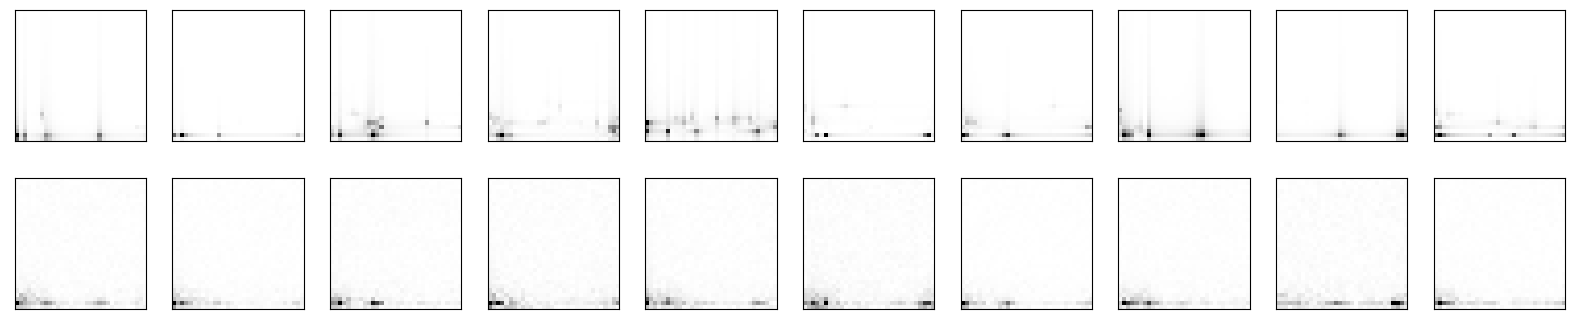

In [11]:
# Display the original and reconstructed pseudo-gray plots of the magnitude of channel H
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1 )
  x_testplo = abs(x_test[i, 0, :, :]-0.5 + 1j*(x_test[i, 1, :, :]-0.5))
  plt.imshow(np.max(np.max(x_testplo))-x_testplo.T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.invert_yaxis()
  
  # display reconstructed
  ax = plt.subplot(2, n, i + 1 + n)
  decoded_imgsplo = abs(x_hat[i, 0, :, :]-0.5
                        + 1j*(x_hat[i, 1, :, :]-0.5))
  plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.invert_yaxis()

plt.show()

In [ ]:
# Save the autoencoder model as JSON and the weights as HDF5 
model_json = autoencoder.to_json()
outfile = "files_06_channel/result/sbrt_model_%s.json"%file
with open(outfile, "w") as json_file:
  json_file.write(model_json)
outfile = "files_06_channel/result/sbrt_model_%s.h5"%file
autoencoder.save_weights(outfile)

## Authors

- [Lucas Damasceno - LASSE/UFPA](https://github.com/LucasDamascenoS)
- Marcos Davi - LASSE/UFPA